## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

## What we're going to cover


* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)

## Get Data

I download the history bitcoin price data from  **- Sep 15, 2014 - Mar 04, 2024 -**, that i found in this link: [Bitcoin Data](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410825600&period2=1709596800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

### Download Bitcoin data

In [141]:
import pandas as pd

bitcoin_data = pd.read_csv("BTC-USD.csv", parse_dates=["Date"])

bitcoin_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3458 non-null   datetime64[ns]
 1   Open       3458 non-null   float64       
 2   High       3458 non-null   float64       
 3   Low        3458 non-null   float64       
 4   Close      3458 non-null   float64       
 5   Adj Close  3458 non-null   float64       
 6   Volume     3458 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 189.2 KB


### How many data do we have in the past 10 years

In [4]:
# How many sample do we have for 10 years of data
len(bitcoin_data)

3458

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

## Visualize the Data

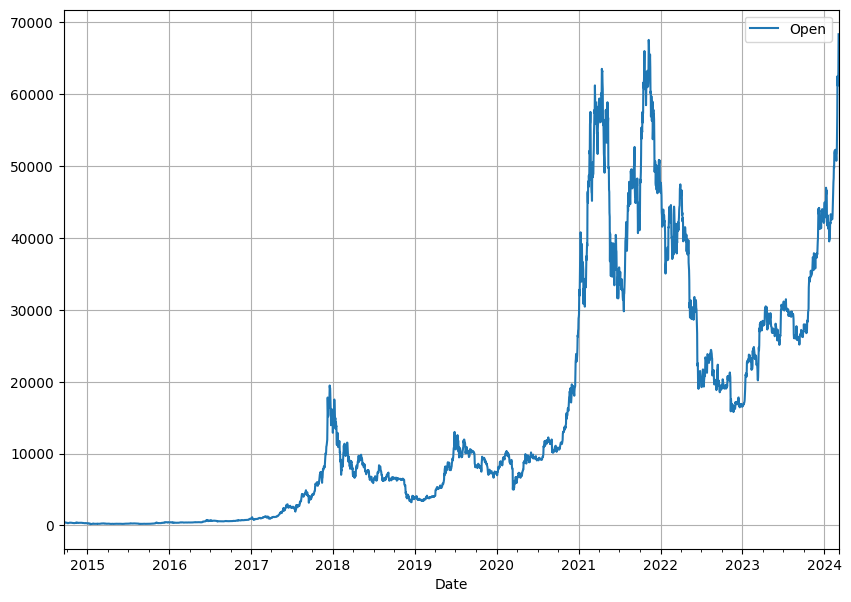

In [142]:
import matplotlib.pyplot as plt
bitcoin_data.plot(x='Date',figsize=(10,7,), y= 'Open')
plt.grid(True)

## Create train and test sets of our time series data

If we are trying to predict the future, we need to have a test data of the "future" of our data.

Basically split the data of the end and use it like unseen data

In [143]:
# Split the data 80% & 20%
timesteps = bitcoin_data.index.to_numpy()
prices = bitcoin_data.Close.to_numpy()
split_size = int(0.8 * len(prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create a test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test)

(2766, 692)

### Plot the data

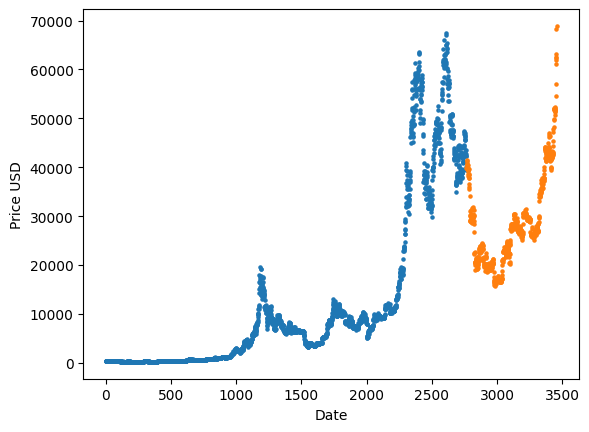

In [144]:
# Scatter plot

plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("Price USD")
plt.show();

### Creating a plotting function

In [145]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, marker='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], marker = marker, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

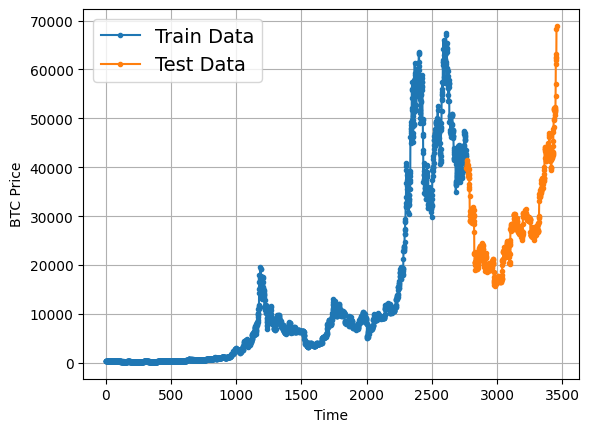

In [146]:
plot_time_series(X_train, y_train, label = "Train Data")
plot_time_series(X_test, y_test, label = "Test Data")

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

First we'll need TensorFlow.


In [10]:
import tensorflow as tf
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


In [11]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [12]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([39935.515625, 40553.464844, 40424.484375, 39716.953125,
        40826.214844, 41502.75    , 41374.378906, 40527.363281,
        39740.320313, 39486.730469]),
 array([51571.101563, 51733.238281, 54522.402344, 57085.371094,
        62504.789063, 61198.382813, 62440.632813, 62029.847656,
        63167.371094, 68330.414063]))

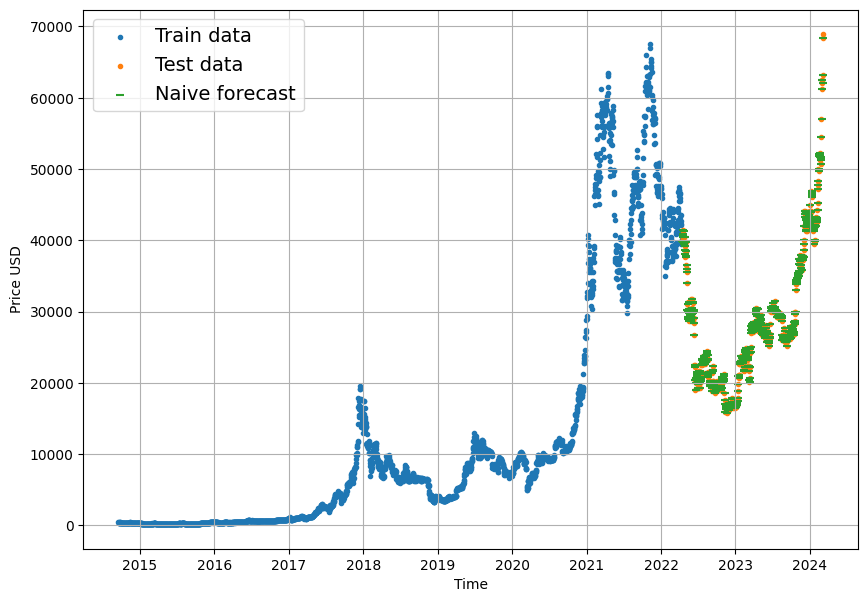

In [13]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, marker="_", label="Naive forecast");

In [14]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 519.4168,
 'mse': 682817.44,
 'rmse': 826.3277,
 'mape': 1.8239484,
 'mase': 1.000275}

## Format Data Windows and Horizons


In [15]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

## Model 1: N-Beats: Neural Basis Exapnsion Analysis

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We're not going to go through all of the details in the paper, instead we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implementing a custom architecture using the Functional API
* Finding a paper related to our problem and seeing how it goes

> 🔑 **Note:** As you'll see in the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what we'll be doing too!

In [16]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [34]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [35]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [36]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.21257395 -0.46355486 -0.33335778  0.8373023   0.07625225  1.0322436
  0.5764232 ]
Forecast: -0.3225889205932617


In [37]:
#bitcoin_data = bitcoin_data.set_index('Date')
bitcoin_prices = bitcoin_data['Open']
bitcoin_prices = pd.DataFrame(bitcoin_prices)
bitcoin_prices.head()

,Open
Date,
2014-09-17,465.864014
2014-09-18,456.859985
2014-09-19,424.102997
2014-09-20,394.673004
2014-09-21,408.084991


In [33]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Open+{i+1}"] = bitcoin_prices_nbeats["Open"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Open,Open+1,Open+2,Open+3,Open+4,Open+5,Open+6,Open+7
Date,,,,,,,,
2014-09-24,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997,456.859985,465.864014
2014-09-25,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997,456.859985
2014-09-26,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997
2014-09-27,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004
2014-09-28,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991


In [38]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Open", axis=1)
y = bitcoin_prices_nbeats.dropna()["Open"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2760, 2760, 691, 691)

In [39]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [40]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
# Make tensors

tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm


1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [44]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_1 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_1_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_1.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 391: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 491: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1h 25min 42s, sys: 1min 4s, total: 1h 26min 47s
Wall time: 1h 7min 25s


In [45]:
# Evaluate N-BEATS model on the test dataset
model_1.evaluate(test_dataset)

1/1 [==============================] - 0s 388ms/step - loss: 526.8054 - mae: 526.8054 - mse: 702188.8125


[526.805419921875, 526.805419921875, 702188.8125]

In [48]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [49]:
# Make predictions with N-BEATS model
model_1_preds = make_preds(model_1, test_dataset)
model_1_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40884.664, 40310.625, 40550.676, 40125.492, 39751.34 , 40637.227,
       41277.47 , 41386.13 , 40674.19 , 39723.16 ], dtype=float32)>

In [50]:
# Evaluate N-BEATS model predictions
model_1_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_1_preds)
model_1_results

{'mae': 526.8054,
 'mse': 702188.8,
 'rmse': 837.96704,
 'mape': 1.8662503,
 'mase': 1.0106193}

### Redefine our historical data

In [55]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_nbeats.drop(["Open"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_nbeats.dropna()["Open"].to_numpy()

y_all

array([  435.751007,   423.156006,   411.428986, ..., 62031.578125,
       63137.003906, 68341.054688])

## Predict BitCoin future Price

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)


To do so, we'll build the following steps:
1. Function which takes as input:
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_1`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
  * Eventually future predictions will be made using the model's own previous predictions as input

In [124]:
# How many timesteps to predict into the future?
INTO_FUTURE = 120 # since our Bitcoin data is daily, this is for 14 days

In [125]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [126]:
import numpy as np
future_forecast = make_future_forecast(values=y_all,
                                       model=model_1,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 25ms/step
Predicting on: 
 [57071.097656 62499.183594 61168.0625   62431.652344 62031.578125
 63137.003906 68341.054688] -> Prediction: 57914.3984375

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [62499.183594  61168.0625    62431.652344  62031.578125  63137.003906
 68341.054688  57914.3984375] -> Prediction: 62300.7265625

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [61168.0625    62431.652344  62031.578125  63137.003906  68341.054688
 57914.3984375 62300.7265625] -> Prediction: 63032.84765625

1/1 [==============================] - 0s 24ms/step
Predicting on: 
 [62431.652344   62031.578125   63137.003906   68341.054688
 57914.3984375  62300.7265625  63032.84765625] -> Prediction: 62182.78515625

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [62031.578125   63137.003906   68341.054688   57914.3984375
 62300.7265625  63032.84765625 62182.78515625] -> Prediction: 62512.90625

## Plot future forecasts

This is so exciting! Forecasts made!

But right now, they're just numbers on a page.

Let's bring them to life by adhering to the data explorer's motto: visualize, visualize, visualize!

To plot our model's future forecasts against the historical data of Bitcoin, we're going to need a series of future dates (future dates from the final date of where our dataset ends).

How about we create a function to return a date range from some specified start date to a specified number of days into the future (`INTO_FUTURE`).

To do so, we'll use a combination of NumPy's [`datetime64` datatype](https://numpy.org/doc/stable/reference/arrays.datetime.html) (our Bitcoin dates are already in this datatype) as well as NumPy's `timedelta64` method which helps to create date ranges.

In [127]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [128]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = []
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-03-05 00:00:00')

In [129]:
# Get next two weeks of timesteps
next_time_steps = []
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
       '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
       '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
       '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
       '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
       '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
       '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
       '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-06',
       '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10',
       '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
       '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
       '2024-04-19', '2024-04-20', '2024-04-21', '2024-04-22',
       '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
       '2024-04-27', '2024-04-28', '2024-04-29', '2024-04-30',
       '2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04',
       '2024-05-05', '2024-05-06', '2024-05-07', '2024-

In [130]:
bitcoin_prices.Open[-1]

68341.054688

In [131]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, bitcoin_prices.Open[-1])
next_time_steps.shape, future_forecast.shape, bitcoin_prices.Open.shape, bitcoin_prices.index.shape

((121,), (121,), (3458,), (3458,))

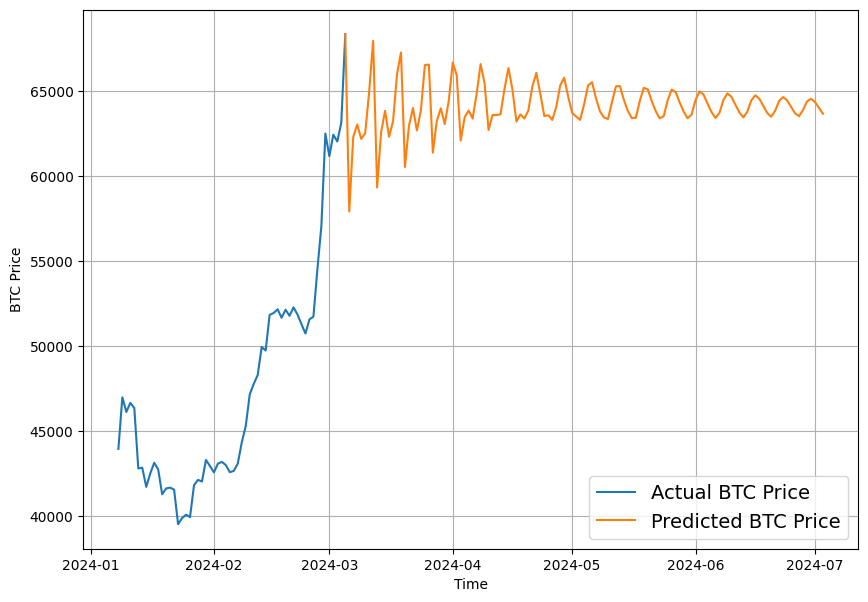

In [152]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, bitcoin_prices.Open, marker=None, start= 3400, label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, marker=None, label="Predicted BTC Price")